In [1]:
import itertools
import numpy as np
from sklearn.neighbors import KDTree
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm, tqdm_notebook

In [2]:
def euc_dist(v1, v2):
    return np.sqrt(np.sum((v1 - v2) ** 2))

In [3]:
def get_keypoints(im, k=5):
    """Get keypoints
    
    Args:
        im: Grayscale image
    
    Return:
        Keypoints
    """
    # initialize keypoints
    keypoint_indices = set()
    keypoints = list()    
    
    # threshold
    _, im_binary = cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)    
    
    # get connected components
    # - centroids: x, y
    retval, labels, stats, centroids = cv2.connectedComponentsWithStats(im_binary)

    # form KDTree
    kd_tree = KDTree(centroids)
    
    # get neighbours
    for i in tqdm(range(centroids.shape[0])):
        closest_indices = kd_tree.query(centroids[i][np.newaxis, ...], k=k, return_distance=False).flatten()
        triangles = itertools.combinations(closest_indices, 3)
        for triangle in triangles:
            triangle = list(triangle)
            if tuple(sorted(triangle)) not in keypoint_indices:
                # get lengths of triangle
                l1 = euc_dist(centroids[triangle[0]], centroids[triangle[1]])
                l2 = euc_dist(centroids[triangle[1]], centroids[triangle[2]])
                l3 = euc_dist(centroids[triangle[0]], centroids[triangle[2]])
                # get centroid of triangle
                triangle_centroid = np.mean(centroids[triangle], axis=0)
                # add
                triangle_lengths = sorted([l1, l2, l3])
                kp_feature = np.array([triangle_lengths[0] / triangle_lengths[1], 
                                       triangle_lengths[1] / triangle_lengths[2]])
                keypoints.append((triangle_centroid, 
                                  kp_feature, 
                                  np.array([centroids[triangle[0]], centroids[triangle[1]], centroids[triangle[2]]])))
                keypoint_indices.add(tuple(sorted(triangle)))
    
    return keypoints


In [4]:
im_big = cv2.imread("./images/StarMap.png", cv2.IMREAD_GRAYSCALE)
im1 = cv2.imread("./images/Small_area.png", cv2.IMREAD_GRAYSCALE)
im2 = cv2.imread("./images/Small_area_rotated.png", cv2.IMREAD_GRAYSCALE)

# Get Keypoints

In [5]:
kp_im_big = get_keypoints(im_big)
kp_im1 = get_keypoints(im1)
kp_im2 = get_keypoints(im2)

100%|██████████| 54/54 [00:00<00:00, 3735.03it/s]


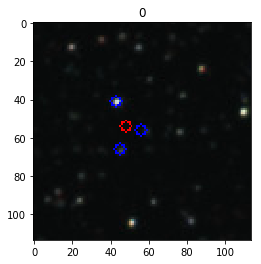

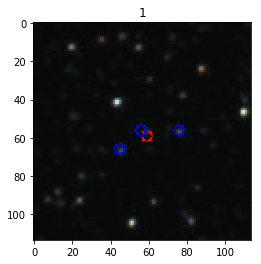

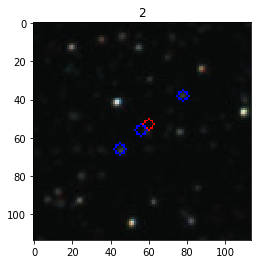

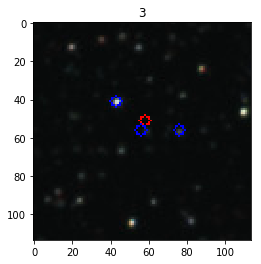

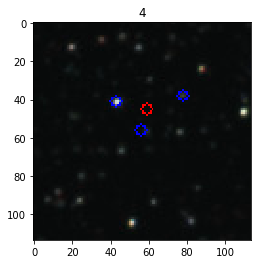

In [6]:
# blue points are corners of the triangles, red is the centroid of the triangle
for i, k in enumerate(kp_im1[:5]):
    im_to_draw = cv2.imread("./images/Small_area.png").copy()
    # centroid
    cv2.circle(im_to_draw, (int(k[0][0]), int(k[0][1])), 3, (255, 0, 0), 1)
    # corners
    cv2.circle(im_to_draw, (int(k[2][0][0]), int(k[2][0][1])), 3, (0, 0, 255), 1)
    cv2.circle(im_to_draw, (int(k[2][1][0]), int(k[2][1][1])), 3, (0, 0, 255), 1)
    cv2.circle(im_to_draw, (int(k[2][2][0]), int(k[2][2][1])), 3, (0, 0, 255), 1)
    # Plot
    fig = plt.figure()
    plt.imshow(im_to_draw); 
    plt.title(i)

# Keypoint Matching

In [7]:
X_im_big = np.array([_[1] for _ in kp_im_big])
X_im1 = np.array([_[1] for _ in kp_im1])
X_im2 = np.array([_[1] for _ in kp_im2])

In [8]:
# get closest matches
kd_tree_im_big = KDTree(X_im_big, leaf_size=2, metric='l1')
closest_matches1 = kd_tree_im_big.query(X_im1, k=1)

In [9]:
kps_in_im_big = [kp_im_big[i][0] for i in closest_matches1[1].squeeze()]

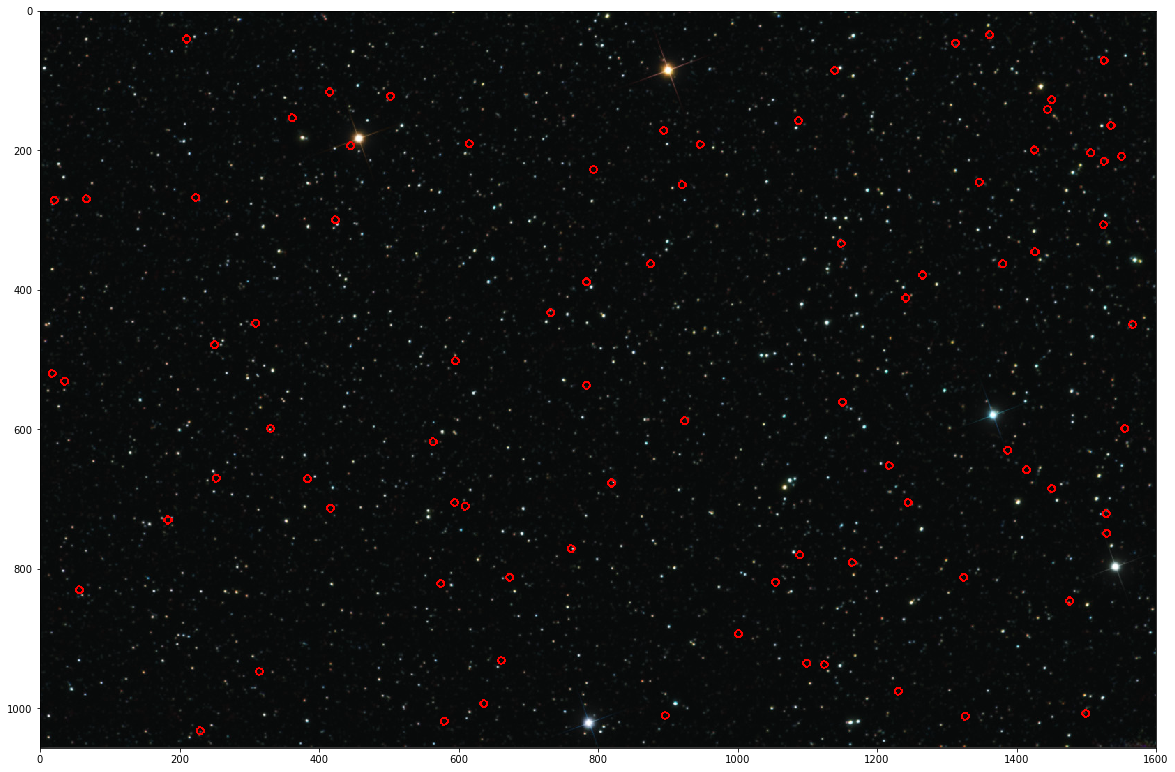

In [10]:
im_big_to_draw = cv2.imread("./images/StarMap.png").copy()
for k in kps_in_im_big:
    cv2.circle(im_big_to_draw, (int(k[0]), int(k[1])), 5, (255, 0, 0), 2)
    
# Plot
fig = plt.figure(figsize=(20, 20))
plt.imshow(im_big_to_draw)